In [1]:


!pip install langchain langchain-community
!pip install qdrant-client
!pip install sentence-transformers
!pip install groq
!pip install pypdf
!pip install python-dotenv

INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.3/337.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [2]:
import os
from typing import List
import uuid

# LangChain imports
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Qdrant
from langchain.chains import RetrievalQA
from langchain.llms.base import LLM
from langchain.callbacks.manager import CallbackManagerForLLMRun

# Qdrant
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

# Groq
from groq import Groq

print("All libraries are imported successfully ")

All libraries are imported successfully 


In [ ]:
GROQ_API_KEY = "gsk_***************************"## blurred not for github 

In [4]:


class GroqLLM(LLM):
    """Custom LangChain LLM wrapper for Groq API"""

    groq_api_key: str
    model_name: str = "llama-3.1-8b-instant"
    temperature: float = 0.0
    max_tokens: int = 1000

    @property
    def _llm_type(self) -> str:
        return "groq"

    def _call(
        self,
        prompt: str,
        stop: List[str] = None,
        run_manager: CallbackManagerForLLMRun = None,
        **kwargs
    ) -> str:
        """Call Groq API"""
        client = Groq(api_key=self.groq_api_key)

        response = client.chat.completions.create(
            model=self.model_name,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            max_tokens=self.max_tokens
        )

        return response.choices[0].message.content

# Initialize Groq LLM
llm = GroqLLM(groq_api_key=GROQ_API_KEY)

print("Groq LLM initialized")
print(f"Model: llama-3.1-8b-instant")

Groq LLM initialized
Model: llama-3.1-8b-instant


In [5]:


# This experiment was done in ggogle colab
from google.colab import files
print("Upload your PDF file:")
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
print(f"File uploaded: {pdf_path}")


Upload your PDF file:


Saving sample_rag_nepal.pdf to sample_rag_nepal.pdf
File uploaded: sample_rag_nepal.pdf


In [6]:
print(f"Loading PDF: {pdf_path}")

# Load PDF
loader = PyPDFLoader(pdf_path)
pages = loader.load()

print(f"PDF loaded successfully!")
print(f"Total pages: {len(pages)}")
print(f"Total characters: {sum(len(page.page_content) for page in pages)}")

# Preview first 500 characters
print("\n Preview of content:")
print("=" * 80)
print(pages[0].page_content[:500])
print("=" * 80)

Loading PDF: sample_rag_nepal.pdf
PDF loaded successfully!
Total pages: 10
Total characters: 30696

 Preview of content:
CHAPTER 1 
INTRODUCTION 
1.1 Geography and Economy 
Geography 
Nepal is a land-locked country nestled in the foothills of the Himalayas. It occupies an area from 26 ° 
20' to 30* 10' north latitude and 800 15' to 88 ° 19' east longitude. It shares its northern border with the Tibetan 
region of the People's Republic of China, and its eastern, southern and western borders with India. 
Nepal is rectangular in shape and is approximately 80 miles (128 kilometres) wide and 550 miles (880 
kilometres)


In [7]:
print(" Chunking the document...")

# Creating text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)

# Spliting the documents
chunks = text_splitter.split_documents(pages)

print(f" Document chunked successfully!")
print(f" Total chunks: {len(chunks)}")
print(f" Average chunk size: {sum(len(c.page_content) for c in chunks) / len(chunks):.0f} characters")


print("\n First 3 chunks:")
for i, chunk in enumerate(chunks[:3]):
    print(f"\n--- Chunk {i+1} ---")
    print(chunk.page_content[:200] + "...")

 Chunking the document...
 Document chunked successfully!
 Total chunks: 73
 Average chunk size: 422 characters

 First 3 chunks:

--- Chunk 1 ---
CHAPTER 1 
INTRODUCTION 
1.1 Geography and Economy 
Geography 
Nepal is a land-locked country nestled in the foothills of the Himalayas. It occupies an area from 26 ° 
20' to 30* 10' north latitude an...

--- Chunk 2 ---
kilometres) long. The total land area of the country is 147,181 square kilometres and its population, according 
to the 1991 Census, is 18.5 million. Nepal is predominantly rural with only 9 percent o...

--- Chunk 3 ---
sea level and covers a land area of 51,817 square kilometres. Because of the harsh terrain, transportation and 
communication facilities in this region are very limited and only about 8 percent of the...


In [8]:
print("Loading embedding model...")


# Initializing HuggingFace embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

# Testing the embeddings
test_text = "This is a test sentence."
test_embedding = embeddings.embed_query(test_text)

print(f" Embedding model loaded!")
print(f" Embedding dimensions: {len(test_embedding)}")
print(f"Sample embedding values: {test_embedding[:5]}")

Loading embedding model...


/tmp/ipython-input-3257289272.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 Embedding model loaded!
 Embedding dimensions: 384
Sample embedding values: [0.08429648727178574, 0.05795370414853096, 0.004493366461247206, 0.10582109540700912, 0.0070834411308169365]


In [9]:
print("Setting up Qdrant vector database...")

# Creating in-memory Qdrant client
qdrant_client = QdrantClient(":memory:")

collection_name = "pdf_documents"

# Create collection
qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=384,  # Dimensions of all-MiniLM-L6-v2 model
        distance=Distance.COSINE
    )
)

print(f" Qdrant collection created: {collection_name}")
print(f" Vector size: 384")
print(f" Distance metric: Cosine similarity")

Setting up Qdrant vector database...
 Qdrant collection created: pdf_documents
 Vector size: 384
 Distance metric: Cosine similarity


In [10]:
print(" Generating embeddings and storing in Qdrant...")
print(f"Processing {len(chunks)} chunks...")

# Create Qdrant vector store from documents
vectorstore = Qdrant.from_documents(
    chunks,
    embeddings,
    location=":memory:",
    collection_name=collection_name,
)

print(f" All {len(chunks)} chunks embedded and stored!")
print(f"Vector database ready for queries")

 Generating embeddings and storing in Qdrant...
Processing 73 chunks...
 All 73 chunks embedded and stored!
Vector database ready for queries


In [11]:
# Test a query
test_query = "What is this document about?"

print(f" Testing similarity search...")
print(f"Query: '{test_query}'")
print("\n" + "=" * 80)

# Search for similar chunks
results = vectorstore.similarity_search_with_score(test_query, k=3)

for i, (doc, score) in enumerate(results):
    print(f"\n Result {i+1} (Similarity: {score:.4f}):")
    print("-" * 80)
    print(doc.page_content[:300])
    print("-" * 80)

 Testing similarity search...
Query: 'What is this document about?'


 Result 1 (Similarity: 0.2567):
--------------------------------------------------------------------------------
Manual, which described the administrative and logistical aspects of training and data quality checks. The 
Household Listing Manual described the mapping and household listing procedures used in DHS surveys. 
The NFHS fieldwork was carried out by 12 teams, each comprised of three female interviewer
--------------------------------------------------------------------------------

 Result 2 (Similarity: 0.2455):
--------------------------------------------------------------------------------
purpose of this report was to disseminate the basic findings of the NFHS to policy-makers, programme planners, 
and administrators. The report contained 19 tables and findings on fertility, awareness and practice of family 
planning, fertility preferences, utilization of antenatal services, unmet ne
--------------------

In [12]:
## Creating RAG Chain
# Create retriever
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}  # Retrieving top 5 similar
)

# Create RAG chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # "stuff" means put all retrieved docs into prompt
    retriever=retriever,
    return_source_documents=True,
    verbose=True
)

print(" RAG chain created successfully")


 RAG chain created successfully


In [13]:
def ask_question(question: str):
    print(f" QUESTION: {question}")
    result = qa_chain({"query": question})
    print("\n ANSWER:")
    print(result['result'])
    print("\n SOURCES:")
    for i, doc in enumerate(result['source_documents']):
        print(f"\n--- Source {i+1} ---")
        print(doc.page_content[:200] + "...")

    return result

# Example
result1 = ask_question("What is the main topic of this document?")

 QUESTION: What is the main topic of this document?


> Entering new RetrievalQA chain...


/tmp/ipython-input-1693057869.py:3: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": question})



> Finished chain.

 ANSWER:
The main topic of this document appears to be the National Family Health Survey (NFHS) and its findings, specifically in relation to population policies, family planning, reproductive health, and maternal and child health in a particular country (though the country is not specified).

 SOURCES:

--- Source 1 ---
following topics: 
• Background characteristics including age, education, religion; 
• Reproductive history; 
• Knowledge and use of family planning methods; 
• Fertility preferences and attitudes abo...

--- Source 2 ---
programmes. The ministry is primarily responsible for formulating and implementing population policies, plans, 
and programmes, and for monitoring and evaluating these programmes. This ministry, along...

--- Source 3 ---
of view. From the Fifth Plan until the end of the Seventh Plan (1985-1990) population policies and programmes 
not only emphasized family planning issues in the short run, but also focussed on long-te...

--- Sour

In [14]:
def inspect_retrieval(question: str, k: int = 5):
    print(f"\n Inspecting retrieval for: '{question}'")

    docs_with_scores = vectorstore.similarity_search_with_score(question, k=k)

    for i, (doc, score) in enumerate(docs_with_scores):
        print(f"\n📄 Chunk {i+1} (Similarity Score: {score:.4f}) \n")
        print(doc.page_content)
inspect_retrieval("What is this document about?", k=3)


 Inspecting retrieval for: 'What is this document about?'

📄 Chunk 1 (Similarity Score: 0.2567) 

Manual, which described the administrative and logistical aspects of training and data quality checks. The 
Household Listing Manual described the mapping and household listing procedures used in DHS surveys. 
The NFHS fieldwork was carried out by 12 teams, each comprised of three female interviewers, one male 
interviewer, a female field editor, and a field supervisor who was either male or female (see Appendix D for a

📄 Chunk 2 (Similarity Score: 0.2455) 

purpose of this report was to disseminate the basic findings of the NFHS to policy-makers, programme planners, 
and administrators. The report contained 19 tables and findings on fertility, awareness and practice of family 
planning, fertility preferences, utilization of antenatal services, unmet need, immunizations, health of children, 
infant and child mortality, and knowledge about AIDS. 
The NFHS followed the DHS tabulation plan 

In [15]:
print(" Interactive Q&A Mode")
print("Type your questions (or 'quit' to exit)")

while True:
    question = input("\n Your question: ").strip()

    if question.lower() in ['quit', 'exit', 'q']:
        print(" Goodbye!")
        break

    if not question:
        print(" Please enter a question")
        continue

    try:
        result = ask_question(question)
    except Exception as e:
        print(f" Error: {e}")

 Interactive Q&A Mode
Type your questions (or 'quit' to exit)

 Your question: where is  nepal?
 QUESTION: where is  nepal?


> Entering new RetrievalQA chain...

> Finished chain.

 ANSWER:
Nepal is a land-locked country nestled in the foothills of the Himalayas. It shares its northern border with the Tibetan region of the People's Republic of China, and its eastern, southern, and western borders with India.

 SOURCES:

--- Source 1 ---
CHAPTER 1 
INTRODUCTION 
1.1 Geography and Economy 
Geography 
Nepal is a land-locked country nestled in the foothills of the Himalayas. It occupies an area from 26 ° 
20' to 30* 10' north latitude an...

--- Source 2 ---
kilometres) long. The total land area of the country is 147,181 square kilometres and its population, according 
to the 1991 Census, is 18.5 million. Nepal is predominantly rural with only 9 percent o...

--- Source 3 ---
sea level and covers a land area of 51,817 square kilometres. Because of the harsh terrain, transportation and 
co

In [16]:


print(" STATISTICS")
# Document
total_chars = sum(len(chunk.page_content) for chunk in chunks)
print(f" Total pages in PDF: {len(pages)}")
print(f" Total chunks created: {len(chunks)}")
print(f" Total characters: {total_chars:,}")
print(f" Average chunk size: {total_chars / len(chunks):.0f} characters")

# Vector store
print(f"\n Vector Database:")
print(f"   Collection: {collection_name}")
print(f"   Vectors stored: {len(chunks)}")
print(f"   Vector dimensions: 384")
print(f"   Distance metric: Cosine")

# Embedding model
print(f"\n Embedding Model:")
print(f"   Model: all-MiniLM-L6-v2")
print(f"   Size: ~80MB")
print(f"   Dimensions: 384")

# LLM
print(f"\n Language Model:")
print(f"   Provider: Groq")
print(f"   Model: llama-3.1-8b-instant")
print(f"   Temperature: 0.0 (deterministic)")


 STATISTICS
 Total pages in PDF: 10
 Total chunks created: 73
 Total characters: 30,782
 Average chunk size: 422 characters

 Vector Database:
   Collection: pdf_documents
   Vectors stored: 73
   Vector dimensions: 384
   Distance metric: Cosine

 Embedding Model:
   Model: all-MiniLM-L6-v2
   Size: ~80MB
   Dimensions: 384

 Language Model:
   Provider: Groq
   Model: llama-3.1-8b-instant
   Temperature: 0.0 (deterministic)


In [17]:
def test_retrieval_parameters(question: str):
    """Compare results with different k values"""
    print(f"\n Testing different retrieval parameters")
    print(f"Question: '{question}'")
    print("=" * 80)

    for k in [3, 5, 10]:
        print(f"\n Retrieving top {k} chunks:")

        # Create retriever with different k
        temp_retriever = vectorstore.as_retriever(
            search_type="similarity",
            search_kwargs={"k": k}
        )

        # Get documents
        docs = temp_retriever.get_relevant_documents(question)

        print(f"   Retrieved: {len(docs)} chunks")
        print(f"   Total characters: {sum(len(d.page_content) for d in docs)}")

# Test
test_retrieval_parameters("What is this document about?")


 Testing different retrieval parameters
Question: 'What is this document about?'

 Retrieving top 3 chunks:
   Retrieved: 3 chunks
   Total characters: 1319

 Retrieving top 5 chunks:
   Retrieved: 5 chunks
   Total characters: 1833

 Retrieving top 10 chunks:
   Retrieved: 10 chunks
   Total characters: 4069


/tmp/ipython-input-1800351242.py:17: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = temp_retriever.get_relevant_documents(question)


In [18]:
def custom_prompt_query(question: str, custom_instruction: str):
    """Query with custom instructions"""

    docs = retriever.get_relevant_documents(question)
    context = "\n\n".join([doc.page_content for doc in docs])
    prompt = f"""{custom_instruction}

Context from document:
{context}

Question: {question}

Answer:"""

    # response usig Groq
    client = Groq(api_key=GROQ_API_KEY)
    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0
    )

    return response.choices[0].message.content

print("Test 1: Concise answers")
answer1 = custom_prompt_query(
    "What is this document about?",
    "Answer in one concise sentence."
)
print(answer1)

# Example 2: Detailed answers
print("Test 2: Detailed answers")
answer2 = custom_prompt_query(
    "What is this document about?",
    "Provide a detailed explanation with key points."
)
print(answer2)

# Example 3: Bullet points
print("Test 3: Bullet point format")
answer3 = custom_prompt_query(
    "What are the main points?",
    "List the main points as bullet points."
)
print(answer3)

Test 1: Concise answers
This document appears to be a report on the findings of the National Family Health Survey (NFHS) in a specific country, likely India, based on data collected in 1995-1996.
Test 2: Detailed answers
This document appears to be a report on the National Family Health Survey (NFHS) conducted in a specific country. The report provides an overview of the survey's methodology, data collection, and analysis, as well as the key findings and recommendations.

**Key Points:**

1. **Purpose of the Report:** The report aims to disseminate the basic findings of the NFHS to policy-makers, programme planners, and administrators.
2. **Survey Methodology:** The NFHS followed the DHS (Demographic and Health Surveys) tabulation plan to maintain data comparability with other countries.
3. **Data Collection:** The survey was conducted by 12 teams, each consisting of three female interviewers, one male interviewer, a female field editor, and a field supervisor.
4. **Data Entry and Edit

In [19]:
print(" Comparing Chunking Strategies")

#  Small chunks
splitter_small = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=30
)
chunks_small = splitter_small.split_documents(pages)

#  Medium chunks
splitter_medium = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)
chunks_medium = splitter_medium.split_documents(pages)

#  Large chunks
splitter_large = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100
)
chunks_large = splitter_large.split_documents(pages)

print(f" Small chunks (300 chars):  {len(chunks_small)} chunks")
print(f" Medium chunks (500 chars): {len(chunks_medium)} chunks")
print(f" Large chunks (1000 chars): {len(chunks_large)} chunks")

 Comparing Chunking Strategies
 Small chunks (300 chars):  134 chunks
 Medium chunks (500 chars): 73 chunks
 Large chunks (1000 chars): 36 chunks


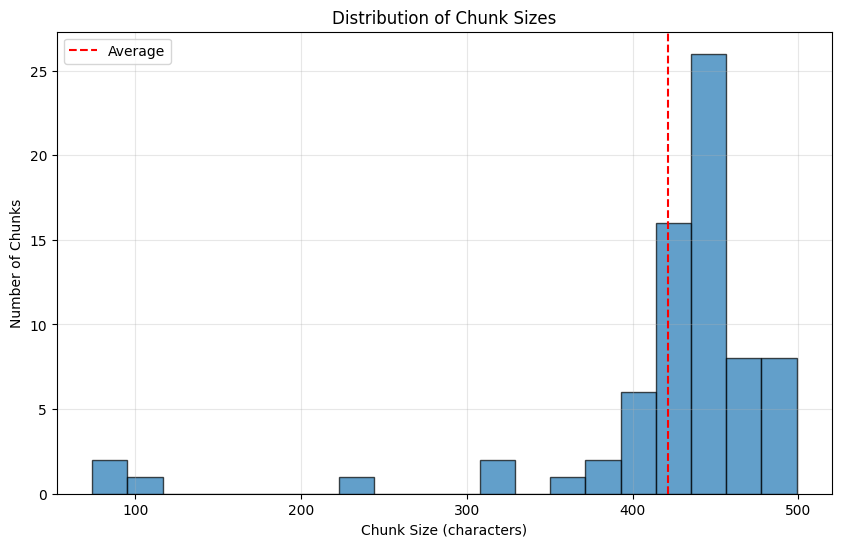

 Average chunk size: 422 characters
 Minimum chunk size: 74 characters
 Maximum chunk size: 499 characters


In [20]:
import matplotlib.pyplot as plt

chunk_sizes = [len(chunk.page_content) for chunk in chunks]

plt.figure(figsize=(10, 6))
plt.hist(chunk_sizes, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Chunk Size (characters)')
plt.ylabel('Number of Chunks')
plt.title('Distribution of Chunk Sizes')
plt.axvline(x=sum(chunk_sizes)/len(chunk_sizes), color='r', linestyle='--', label='Average')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f" Average chunk size: {sum(chunk_sizes)/len(chunk_sizes):.0f} characters")
print(f" Minimum chunk size: {min(chunk_sizes)} characters")
print(f" Maximum chunk size: {max(chunk_sizes)} characters")

In [21]:
### This is done for now